# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Import training and test data

In [2]:
train_data = pd.read_csv('movement_data/fingerprinting_data/train.csv')
test_data = pd.read_csv('movement_data/fingerprinting_data/test.csv')

# Prepare data for model training and validation

In [3]:
def normalise_impute_input(input_features):
    """
    This function normalises the RSSI values into values that fall between 0 and 1.
    Any missing values will be given the maximum value of 1.
    """
    input_features = np.abs(input_features)  # ensure that all rssi values are positive
    num_features = len(input_features[0,:])
    max_value = np.zeros(num_features)
    min_value = np.zeros(num_features)

    for i in range(num_features):
        min_value[i] = np.nanmin(input_features[:,i])
        max_value[i] = np.nanmax(input_features[:,i])
        input_features[:,i] = (input_features[:,i] - min_value[i]) / (max_value[i] - min_value[i] + 1e-6)
    
    input_features[np.isnan(input_features)] = 1.0
        
    return input_features

In [4]:
def prepare_data(data, label_column):
    """
    This function splits the data into input features and labels and returns them as outputs.
    """
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle the data
    
    X = data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].values
    X = normalise_impute_input(X)
    Y = data[label_column]
    
    return X, Y

In [5]:
# Preparing train, test data for hierarchical classification
Xtrain, Ytrain = prepare_data(train_data, 'Model1')
Xtest, Ytest = prepare_data(test_data, 'Model1')

# Preparing train, test data for stage 1 classification
Xtrain_stage1, Ytrain_stage1 = prepare_data(train_data, 'Model2_Stage1')
Xtest_stage1, Ytest_stage1 = prepare_data(test_data, 'Model2_Stage1')

# Preparing train, test data for stage 2 classification (office area)
Xtrain_officearea, Ytrain_officearea = prepare_data(train_data[train_data['Model2_Stage1'] == 'OfficeArea'], 'Model2_Stage2')
Xtest_officearea, Ytest_officearea = prepare_data(test_data[test_data['Model2_Stage1'] == 'OfficeArea'], 'Model2_Stage2')

# Preparing train, test data for stage 2 classification (pantry)
Xtrain_pantry, Ytrain_pantry = prepare_data(train_data[train_data['Model2_Stage1'] == 'Pantry'], 'Model2_Stage2')
Xtest_pantry, Ytest_pantry = prepare_data(test_data[test_data['Model2_Stage1'] == 'Pantry'], 'Model2_Stage2')

/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
/Users/raymondlow/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


# Model training and hyperparameter tuning via random cross validation

In [6]:
def hyperparameter_tuning(Xtrain, Ytrain):
    """
    This function performs hyperparmeter tuning using a 5-fold cross validation approach, based
    on the training dataset and returns the optimised model.
    """
    param_grid = {'n_estimators': np.arange(50, 201, 10),
                  'min_samples_leaf': np.arange(1,6),
                  'min_samples_split': np.arange(2,6),
                  'max_depth': np.arange(2,6)}

    random_cv = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=500, cv=5, verbose=2, scoring='f1_macro', n_jobs=-1)
    random_cv.fit(Xtrain, Ytrain)
    
    print('Best Model Parameters')
    print(random_cv.best_params_)
    
    return random_cv.best_estimator_

In [7]:
# Optimise stage 1 model
stage1_model = hyperparameter_tuning(Xtrain_stage1, Ytrain_stage1)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 47.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 88.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 142.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 206.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 266.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 319.5min finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}


In [8]:
# Optimise stage 2 office area model
officearea_model = hyperparameter_tuning(Xtrain_officearea, Ytrain_officearea)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  9.4min finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}


In [9]:
# Optimise stage 2 pantry model
pantry_model = hyperparameter_tuning(Xtrain_pantry, Ytrain_pantry)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 19.9min finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}


# Calculate test performance of each individual model

In [10]:
def plot_model_performance(true_label, prediction):
    """
    This function compares the predicted location with the true location information
    and presents the model performance using a classification report and a confusion
    matrix.
    """   
    # Classification report
    print(classification_report(true_label, prediction))
    
    # Confusion matrix in the form of a heat map
    cm = confusion_matrix(true_label, prediction)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

                  precision    recall  f1-score   support

   AssemblySpace       0.66      1.00      0.79       210
LaserCuttingRoom       0.88      0.89      0.88       898
     MeetingRoom       0.87      0.52      0.65       279
      OfficeArea       0.96      0.96      0.96      2124
             Out       0.99      1.00      1.00       153
          Pantry       0.86      0.98      0.91       777
   PrecisionRoom       1.00      0.50      0.66       263
         Printer       0.82      0.74      0.78       146
 PrototypingRoom       0.65      0.74      0.69       214

        accuracy                           0.89      5064
       macro avg       0.85      0.81      0.81      5064
    weighted avg       0.90      0.89      0.88      5064



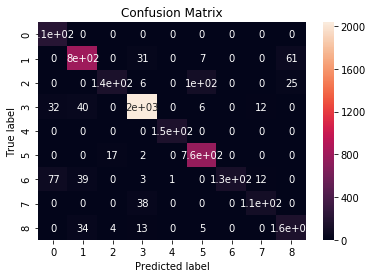

In [11]:
# Model performance of stage 1 model
stage1_prediction = stage1_model.predict(Xtest_stage1)
plot_model_performance(Ytest_stage1, stage1_prediction)

              precision    recall  f1-score   support

OfficeArea_1       0.98      0.85      0.91       911
OfficeArea_2       0.90      0.99      0.94      1213

    accuracy                           0.93      2124
   macro avg       0.94      0.92      0.92      2124
weighted avg       0.93      0.93      0.93      2124



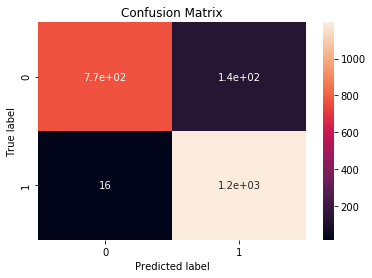

In [12]:
# Model performance of stage 2 office area model
officearea_prediction = officearea_model.predict(Xtest_officearea)
plot_model_performance(Ytest_officearea, officearea_prediction)

                                precision    recall  f1-score   support

    Pantry_FridgeCoffeeMachine       0.34      0.52      0.41       272
Pantry_MicrowaveWaterDispenser       0.55      0.29      0.38       251
                  Pantry_Other       0.33      0.29      0.31       254

                      accuracy                           0.37       777
                     macro avg       0.41      0.37      0.37       777
                  weighted avg       0.40      0.37      0.37       777



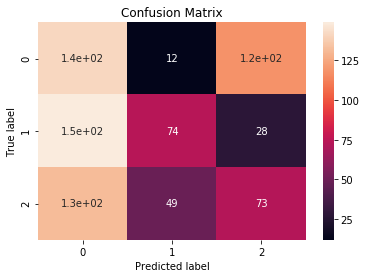

In [13]:
# Model performance of stage 1 model
pantry_prediction = pantry_model.predict(Xtest_pantry)
plot_model_performance(Ytest_pantry, pantry_prediction)

# Calculate the performance of the overall hierarchical model

In [14]:
def perform_hierarhical_classification(stage1_model, officearea_model, pantry_model, stage1_feature_index=list(range(21)), officearea_feature_index=list(range(21)), pantry_feature_index=list(range(21))):
    """
    This function performs hierarchical classification by first performing classification using
    the stage 1 model and following up with a second round of classification for 'OfficeArea' and
    'Pantry' predictions with their respective models.
    """
    final_prediction = stage1_model.predict(Xtest[:,stage1_feature_index])
    for i in range(len(final_prediction)):
        if final_prediction[i] == 'OfficeArea':
            final_prediction[i] = officearea_model.predict(Xtest[i,officearea_feature_index].reshape(1,-1))[0]
        elif final_prediction[i] == 'Pantry':
            final_prediction[i] = pantry_model.predict(Xtest[i,pantry_feature_index].reshape(1,-1))[0]
        else:
            continue
    
    return final_prediction

                                precision    recall  f1-score   support

                 AssemblySpace       0.66      1.00      0.79       210
              LaserCuttingRoom       0.88      0.89      0.88       898
                   MeetingRoom       0.87      0.52      0.65       279
                  OfficeArea_1       0.91      0.74      0.82       911
                  OfficeArea_2       0.84      0.95      0.89      1213
                           Out       1.00      1.00      1.00       154
    Pantry_FridgeCoffeeMachine       0.28      0.56      0.38       272
Pantry_MicrowaveWaterDispenser       0.49      0.25      0.34       251
                  Pantry_Other       0.27      0.22      0.24       254
                 PrecisionRoom       1.00      0.50      0.67       262
                       Printer       0.82      0.74      0.78       146
               PrototypingRoom       0.65      0.74      0.69       214

                      accuracy                           0.75 

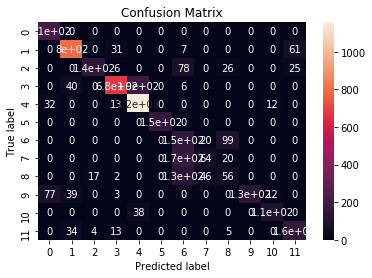

In [15]:
hier_prediction = perform_hierarhical_classification(stage1_model, officearea_model, pantry_model)
plot_model_performance(Ytest, hier_prediction.tolist())

# Reduce input dimensionality using feature importance scores

In [16]:
def plot_feature_importance(model, input_columns):
    """
    This function calculates the feature importance score of each input feature and plots
    them on a pareto chart in descending order.
    """
    cutoff = 1

    feature_importance = pd.DataFrame(model.feature_importances_)
    x_axis = input_columns
    feature_importance.index = x_axis
    feature_importance.columns = ['Feature Importance Score']
    feature_importance.sort_values(by='Feature Importance Score',axis=0,ascending=False, inplace=True)

    pareto_score = []
    total_score = sum(feature_importance['Feature Importance Score'])
    cumulative_score = 0
    for index in feature_importance.index:
        cumulative_score += feature_importance.loc[index,'Feature Importance Score']
        if cumulative_score <= cutoff:
            pareto_score.append(cumulative_score/total_score * 100)
        else:
            break

    feature_importance_cutoff_index = feature_importance.index[:len(pareto_score)]
    print(feature_importance_cutoff_index)
    feature_importance_cutoff = feature_importance.loc[feature_importance_cutoff_index[0]:feature_importance_cutoff_index[len(pareto_score)-1],:]

    fig, ax = plt.subplots()
    fig = plt.xticks(rotation=90)
    fig = sns.barplot(x=feature_importance_cutoff.index,y=feature_importance_cutoff['Feature Importance Score'], ax=ax)
    ax2 = ax.twinx()
    ax2.set_ylabel("Cumulative % of Total Importance Score")
    fig = sns.lineplot(x=np.arange(len(feature_importance_cutoff)), y=pareto_score, ax=ax2, color='black')

Index(['RSSI_Fridge', 'RSSI_LaserCuttingEntrance', 'RSSI_Workshop',
       'RSSI_LabManagerOffice', 'RSSI_AssemblySpace', 'RSSI_PrecisionEntrance',
       'RSSI_ResearcherEntrance', 'RSSI_WaterDispenser', 'RSSI_CoffeeMachine',
       'RSSI_Printer', 'RSSI_Stratasys', 'RSSI_AssemblyEntrance',
       'RSSI_PrototypingEntrance', 'RSSI_Ada', 'RSSI_Microwave',
       'RSSI_3DPrinter', 'RSSI_PrototypingRoom', 'RSSI_LaserCutter',
       'RSSI_Carlye', 'RSSI_MeetingRoom', 'RSSI_PrecisionRoom'],
      dtype='object')


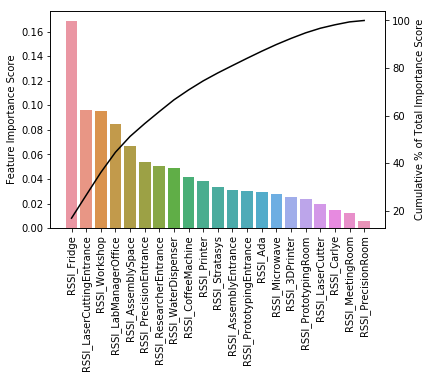

In [18]:
# Plot feature importance score of stage 1 model
input_columns = train_data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].columns.values.tolist()
plot_feature_importance(stage1_model, input_columns)

Index(['RSSI_Ada', 'RSSI_LabManagerOffice', 'RSSI_Stratasys', 'RSSI_Printer',
       'RSSI_ResearcherEntrance', 'RSSI_LaserCutter', 'RSSI_Fridge',
       'RSSI_3DPrinter', 'RSSI_Carlye', 'RSSI_PrototypingRoom',
       'RSSI_AssemblySpace', 'RSSI_PrototypingEntrance', 'RSSI_CoffeeMachine',
       'RSSI_PrecisionEntrance', 'RSSI_Workshop', 'RSSI_LaserCuttingEntrance',
       'RSSI_PrecisionRoom', 'RSSI_WaterDispenser', 'RSSI_Microwave',
       'RSSI_MeetingRoom', 'RSSI_AssemblyEntrance'],
      dtype='object')


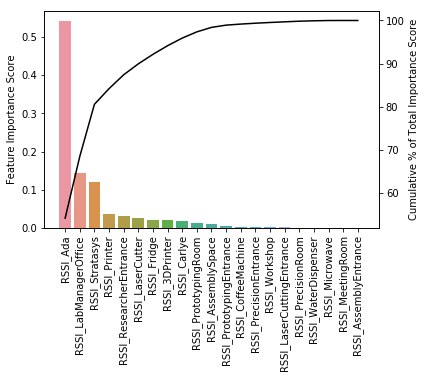

In [19]:
# Plot feature importance score of stage 2 office area model
plot_feature_importance(officearea_model, input_columns)

Index(['RSSI_Workshop', 'RSSI_PrecisionRoom', 'RSSI_Stratasys',
       'RSSI_LabManagerOffice', 'RSSI_PrecisionEntrance', 'RSSI_Microwave',
       'RSSI_Ada', 'RSSI_PrototypingEntrance', 'RSSI_PrototypingRoom',
       'RSSI_CoffeeMachine', 'RSSI_Fridge', 'RSSI_ResearcherEntrance',
       'RSSI_LaserCuttingEntrance', 'RSSI_3DPrinter', 'RSSI_MeetingRoom',
       'RSSI_WaterDispenser', 'RSSI_Printer', 'RSSI_LaserCutter',
       'RSSI_Carlye', 'RSSI_AssemblySpace', 'RSSI_AssemblyEntrance'],
      dtype='object')


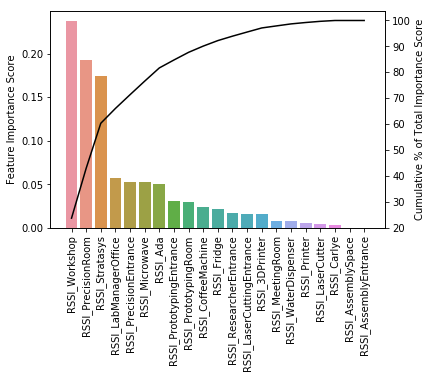

In [20]:
# Plot feature importance score of stage 2 pantry model
plot_feature_importance(pantry_model, input_columns)

In [29]:
stage2_officearea_features = ['RSSI_Ada','RSSI_LabManagerOffice','RSSI_Stratasys','RSSI_Printer','RSSI_ResearcherEntrance',
                              'RSSI_LaserCutter','RSSI_Fridge','RSSI_3DPrinter','RSSI_Carlye','RSSI_PrototypingRoom',
                              'RSSI_AssemblySpace','RSSI_PrototypingEntrance']
officearea_feature_index = [input_columns.index(feature) for feature in stage2_officearea_features]

In [30]:
stage2_pantry_features = ['RSSI_Workshop','RSSI_PrecisionRoom','RSSI_Stratasys','RSSI_LabManagerOffice','RSSI_PrecisionEntrance',
                          'RSSI_Microwave','RSSI_Ada','RSSI_PrototypingEntrance','RSSI_PrototypingRoom','RSSI_CoffeeMachine',
                          'RSSI_Fridge','RSSI_ResearcherEntrance','RSSI_LaserCuttingEntrance', 'RSSI_3DPrinter']
pantry_feature_index = [input_columns.index(feature) for feature in stage2_pantry_features]

# Retrain model based on most significant input features

                  precision    recall  f1-score   support

   AssemblySpace       0.66      1.00      0.79       210
LaserCuttingRoom       0.88      0.89      0.88       898
     MeetingRoom       0.87      0.52      0.65       279
      OfficeArea       0.96      0.96      0.96      2124
             Out       0.99      1.00      1.00       153
          Pantry       0.86      0.98      0.91       777
   PrecisionRoom       1.00      0.50      0.66       263
         Printer       0.82      0.74      0.78       146
 PrototypingRoom       0.65      0.74      0.69       214

        accuracy                           0.89      5064
       macro avg       0.85      0.81      0.81      5064
    weighted avg       0.90      0.89      0.88      5064



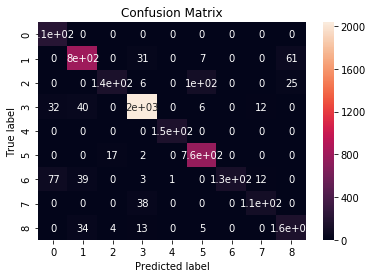

In [33]:
retrained_stage1_model = stage1_model
plot_model_performance(Ytest_stage1, stage1_prediction)

In [34]:
# Retraining stage 2 office area model based on most significant features
retrained_officearea_model = hyperparameter_tuning(Xtrain_officearea[:,officearea_feature_index], Ytrain_officearea)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.1min finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}


              precision    recall  f1-score   support

OfficeArea_1       0.97      0.86      0.91       911
OfficeArea_2       0.90      0.98      0.94      1213

    accuracy                           0.93      2124
   macro avg       0.94      0.92      0.93      2124
weighted avg       0.93      0.93      0.93      2124



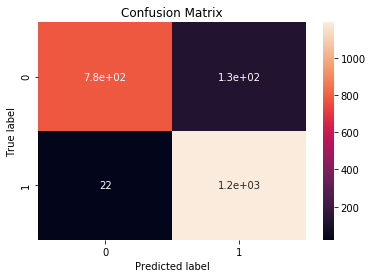

In [35]:
officearea_prediction = retrained_officearea_model.predict(Xtest_officearea[:,officearea_feature_index])
plot_model_performance(Ytest_officearea, officearea_prediction)

In [36]:
# Retraining stage 2 pantry model based on most significant features
retrained_pantry_model = hyperparameter_tuning(Xtrain_pantry[:,pantry_feature_index], Ytrain_pantry)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 16.1min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}


                                precision    recall  f1-score   support

    Pantry_FridgeCoffeeMachine       0.36      0.60      0.45       272
Pantry_MicrowaveWaterDispenser       0.65      0.27      0.38       251
                  Pantry_Other       0.39      0.35      0.37       254

                      accuracy                           0.41       777
                     macro avg       0.47      0.41      0.40       777
                  weighted avg       0.47      0.41      0.40       777



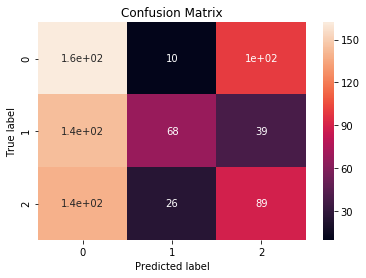

In [37]:
pantry_prediction = retrained_pantry_model.predict(Xtest_pantry[:,pantry_feature_index])
plot_model_performance(Ytest_pantry, pantry_prediction)

# Perform hierarchical classification with the new retrained models

In [39]:
hier_prediction = perform_hierarhical_classification(retrained_stage1_model, retrained_officearea_model, retrained_pantry_model, list(range(21)), officearea_feature_index, pantry_feature_index)

                                precision    recall  f1-score   support

                 AssemblySpace       0.66      1.00      0.79       210
              LaserCuttingRoom       0.88      0.89      0.88       898
                   MeetingRoom       0.87      0.52      0.65       279
                  OfficeArea_1       0.91      0.75      0.82       911
                  OfficeArea_2       0.84      0.95      0.89      1213
                           Out       1.00      1.00      1.00       154
    Pantry_FridgeCoffeeMachine       0.28      0.59      0.38       272
Pantry_MicrowaveWaterDispenser       0.38      0.11      0.17       251
                  Pantry_Other       0.31      0.30      0.31       254
                 PrecisionRoom       1.00      0.50      0.67       262
                       Printer       0.82      0.74      0.78       146
               PrototypingRoom       0.65      0.74      0.69       214

                      accuracy                           0.75 

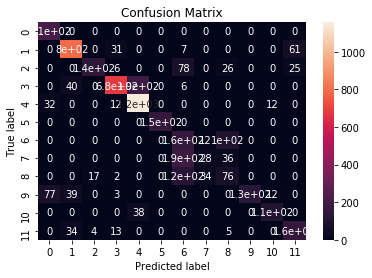

In [40]:
plot_model_performance(Ytest, hier_prediction)